<a href="https://colab.research.google.com/github/zainamri/Kelompok-3-/blob/main/db_scan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mengimpor pustaka yang diperlukan
import numpy as np  # aljabar linier
import pandas as pd  # pemrosesan data, file CSV I/O (misalnya pd.read_csv)
import os  # untuk operasi sistem

# Mengimpor pustaka dari scikit-learn
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import kurtosis
import matplotlib.pyplot as plt

In [ ]:
# Menghubungkan Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Langkah 1: Memuat Dataset  

In [ ]:
# Akses dataset
file_path = ('/content/drive/MyDrive/awikwok/Mall_Customers.csv')
data = pd.read_csv(file_path)
X = data.drop("CustomerID", axis=1)

# Menampilkan beberapa baris pertama dari dataset
data.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


# Langkah 2: Mengkodekan Variabel Kategorikal

In [ ]:
# Mengkodekan variabel kategorikal
le = LabelEncoder()
X["Genre"] = le.fit_transform(X["Genre"])

# Langkah 3: Mengatur Skala Fitur

In [ ]:
# Mengatur skala fitur
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Langkah 4: Menghitung Bobot Fitur Komposit

In [ ]:
# Menghitung bobot fitur komposit berdasarkan varians dan kurtosis
feature_variances = np.var(X_scaled, axis=0)
feature_kurtosis = np.abs(kurtosis(X_scaled, axis=0))

# Normalisasi bobot
normalized_variances = feature_variances / np.sum(feature_variances)
normalized_kurtosis = feature_kurtosis / np.sum(feature_kurtosis)

# Menghitung bobot komposit
composite_weights = normalized_variances * normalized_kurtosis
normalized_composite_weights = composite_weights / np.sum(composite_weights)

# Langkah 5: Menerapkan Pembobotan Fitur  

In [ ]:
# Menerapkan pembobotan fitur
X_weighted = X_scaled * normalized_composite_weights

# Langkah 6: Mendefinisikan Rentang Parameter untuk Pencarian Grid  

In [ ]:
# Pencarian grid untuk gamma dan k yang optimal
gamma_range = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
K_range = range(2, 11)
best_score = -1
best_gamma = None
best_k = None
best_clusters = None

# Langkah 7: Melakukan Pencarian Grid untuk Menemukan Parameter Optimal

In [ ]:
from sklearn.cluster import DBSCAN

# Definisi parameter DBSCAN
eps = 0.5  # Radius lingkungan
min_samples = 5  # Jumlah minimum titik dalam radius untuk menjadi core point

# Menggunakan DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(X_scaled)

# Menghitung jumlah titik noise
num_noise_points = (clusters == -1).sum()
print(f"Jumlah titik noise: {num_noise_points}")

# Menambahkan hasil kluster ke dataset
data["Cluster"] = clusters

# Menyimpan hasil kluster
data[["CustomerID", "Cluster"]].to_csv("dbscan_clusters.csv", index=False)


Jumlah titik noise: 0


# Visualisasi Hasil Klasterisasi DBSCAN

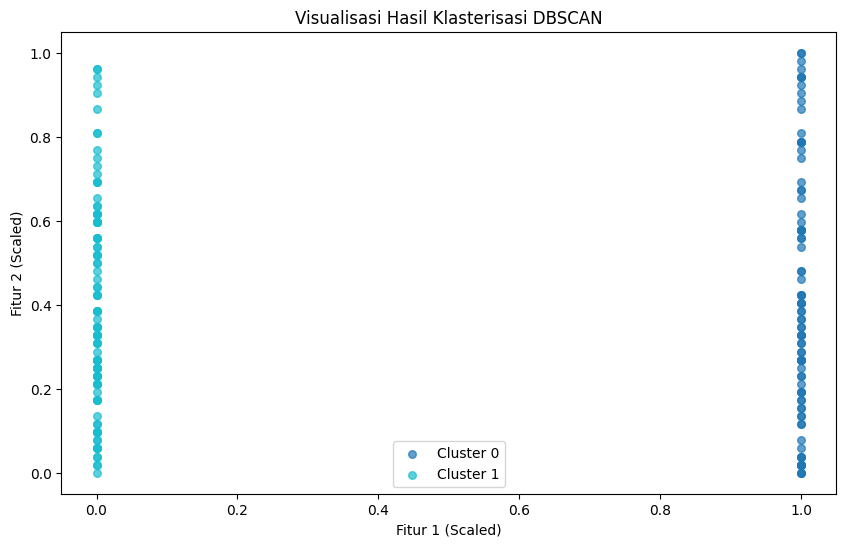

In [ ]:
# Scatter plot hasil klasterisasi DBSCAN
plt.figure(figsize=(10, 6))
unique_clusters = set(clusters)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))

for cluster, color in zip(unique_clusters, colors):
    cluster_mask = (clusters == cluster)
    plt.scatter(
        X_scaled[cluster_mask, 0],
        X_scaled[cluster_mask, 1],
        c=[color],
        label=f"Cluster {cluster}" if cluster != -1 else "Noise",
        s=30, alpha=0.7
    )

plt.title("Visualisasi Hasil Klasterisasi DBSCAN")
plt.xlabel("Fitur 1 (Scaled)")
plt.ylabel("Fitur 2 (Scaled)")
plt.legend()
plt.show()

# Langkah 8: Menerapkan Transformasi Kernel RBF dengan Gamma Terbaik

In [ ]:
# Menerapkan transformasi kernel RBF dengan gamma terbaik
K = rbf_kernel(X_weighted, gamma=best_gamma)

# Langkah 9: Mengurangi Dimensi untuk Visualisasi

In [ ]:
# Mengurangi dimensi untuk visualisasi
pca = PCA(n_components=2)
X_pca = pca.fit_transform(K)

# Langkah 10: Memplot Hasil Klustering

In [ ]:
# Memplot hasil
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_clusters, cmap="viridis")
plt.title("Visualisasi Segmen Pelanggan (PCA)")
plt.xlabel("Komponen Utama Pertama")
plt.ylabel("Komponen Utama Kedua")

# Menyimpan plot
plt.savefig("clusters_visualization.png")  # Pastikan direktori tujuan ada
plt.close()

<ipython-input-62-b31c4f87495b>:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_clusters, cmap="viridis")


# Langkah 11: Mencetak Hasil Klustering Akhir

In [ ]:
# Memeriksa apakah solusi klustering yang valid ditemukan
if best_score > -1:
    # Mencetak skor siluet terbaik yang dicapai
    print(f"Skor Siluet Terbaik: {best_score:.4f}")
    # Mencetak nilai epsilon (gamma) yang menghasilkan skor terbaik
    print(f"Gamma Terbaik: {best_gamma}")
    # Mencetak jumlah kluster yang menghasilkan skor terbaik
    print(f"Jumlah Kluster: {best_k}")
else:
    # Memberitahu pengguna jika tidak ada solusi klustering yang valid ditemukan
    print("Tidak ada solusi klustering yang valid ditemukan")

Tidak ada solusi klustering yang valid ditemukan


# Langkah 12: Menyimpan Penugasan Kluster

In [ ]:
# # Menyimpan penugasan kluster
data["Cluster"] = best_clusters
data[["CustomerID", "Cluster"]].to_csv("submission.csv", index=False)  # Pastikan direktori tujuan ada

# Histogram Jumlah Data per Klaster

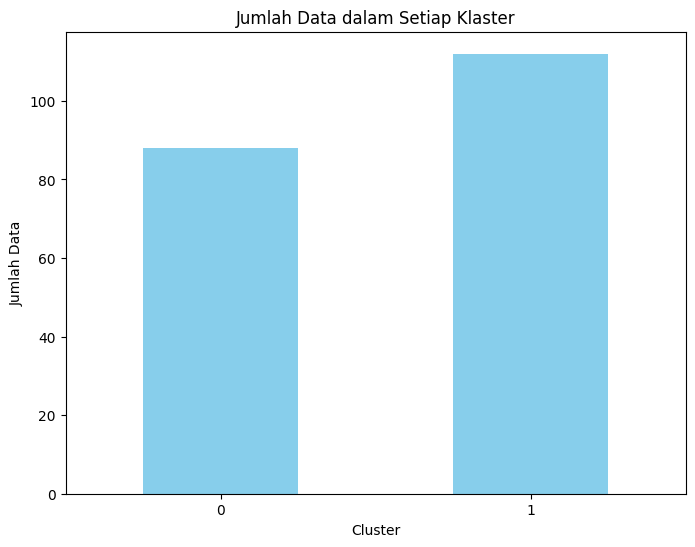

In [ ]:
# Histogram jumlah data dalam setiap klaster
cluster_counts = pd.Series(clusters).value_counts().sort_index()
plt.figure(figsize=(8, 6))
cluster_counts.plot(kind='bar', color='skyblue')
plt.title("Jumlah Data dalam Setiap Klaster")
plt.xlabel("Cluster")
plt.ylabel("Jumlah Data")
plt.xticks(rotation=0)
plt.show()